In [12]:
import cv2 as cv
from matplotlib import pyplot as plt
import pytesseract
import numpy as np

_ = plt.set_cmap("gray")


<Figure size 432x288 with 0 Axes>

In [13]:
print(pytesseract)

<module 'pytesseract' from '/home/bardia/.local/lib/python3.10/site-packages/pytesseract/__init__.py'>


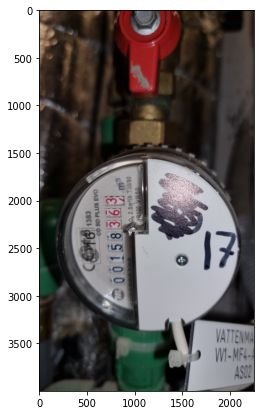

In [14]:
img = cv.imread("img/51_A1002__20220113_233833.jpg")
fig, ax = plt.subplots(1)
fig.set_size_inches(11,7)
_ = ax.imshow(img[:, :, ::-1])


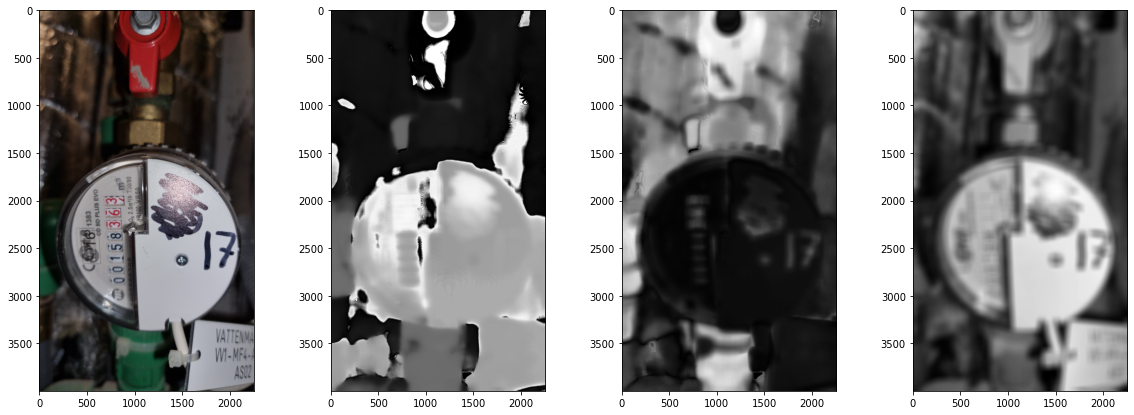

In [15]:
k = 91
b_img = cv.GaussianBlur(img, (k,k), 500)
img_HSV = cv.cvtColor(b_img, cv.COLOR_BGR2HSV_FULL)

fig, ax = plt.subplots(1,4)
fig.set_size_inches(20,7)
_ = ax[0].imshow(img[:,:,::-1])
_ = ax[1].imshow(img_HSV[:, :, 0])
_ = ax[2].imshow(img_HSV[:, :, 1])
_ = ax[3].imshow(img_HSV[:, :, 2])


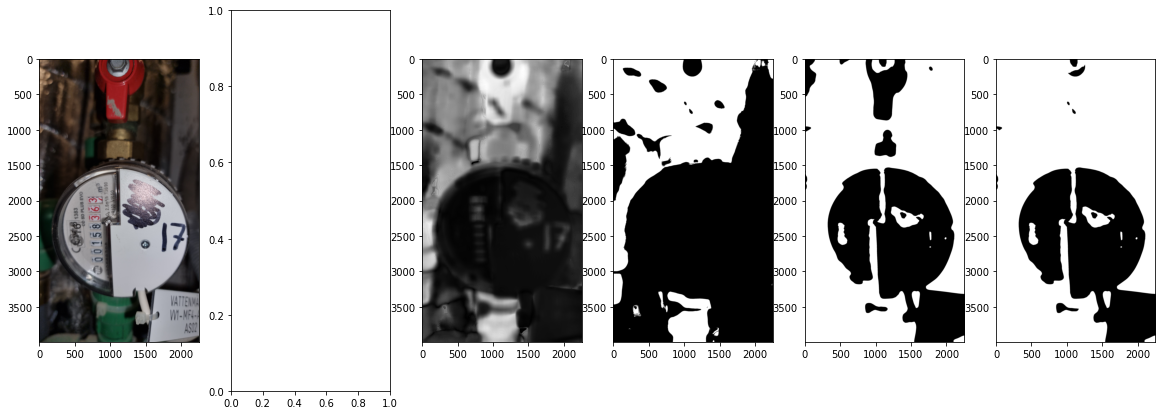

In [16]:
k = 5
b_img_HSV = cv.GaussianBlur(img_HSV,(k,k),0)
hue = b_img_HSV[:,:,0]

ret, thresh1 = cv.threshold(b_img_HSV[:, :, 1], 0, 255, cv.THRESH_OTSU | cv.THRESH_BINARY)
ret, thresh2 = cv.threshold(b_img_HSV[:, :, 2], 0, 255, cv.THRESH_OTSU | cv.THRESH_BINARY_INV)
out_img = thresh2 | thresh1


fig, ax = plt.subplots(1,6)
fig.set_size_inches(20,7)
_ = ax[0].imshow(img[:,:,::-1])
_ = ax[2].imshow(img_HSV[:, :, 1])
_ = ax[3].imshow(thresh1)
_ = ax[4].imshow(thresh2)
_ = ax[5].imshow(out_img)

In [32]:
rect_kernel = cv.getStructuringElement(cv.MORPH_RECT, (18, 18))
dilation = cv.dilate(out_img, rect_kernel, iterations=1)

ones = np.ones(dilation.shape, np.int16)

dilation1 = cv.bitwise_not(dilation)

In [18]:
threshold = 200
canny_img = cv.Canny(dilation, threshold, threshold * 2)

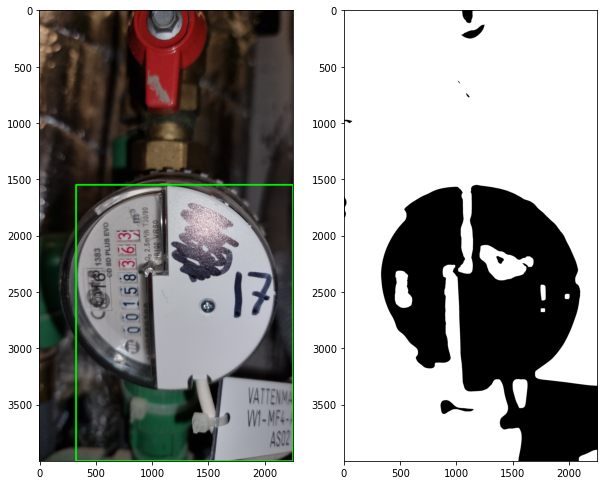

In [19]:
contours, hierarchy = cv.findContours(canny_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

img_cp = img.copy()
mapArea = {w*h: (x,y,w,h) for x,y,w,h in [cv.boundingRect(cnt) for cnt in contours]}
x, y, w, h = mapArea[max(mapArea.keys())]
rect = cv.rectangle(img_cp, (x, y), (x + w, y + h), (0, 255, 0), 14)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 30)

_ = ax[0].imshow(img_cp[:, :, ::-1])
_ = ax[1].imshow(dilation)


## Finalizing

In [20]:
def processMeter(img, k=91):
    # blur the img
    img = img.copy()
    b_img = cv.GaussianBlur(img, (k, k), 500)
    img_HSV = cv.cvtColor(b_img, cv.COLOR_BGR2HSV_FULL)

    saturation = img_HSV[:, :, 1]
    value = img_HSV[:, :, 2]

    _, thresh1 = cv.threshold(saturation, 0, 255, cv.THRESH_OTSU | cv.THRESH_BINARY)
    _, thresh2 = cv.threshold(value, 0, 255, cv.THRESH_OTSU | cv.THRESH_BINARY_INV)
    out_img = thresh2 | thresh1
    threshold = 200
    canny_img = cv.Canny(out_img, threshold, threshold * 2)
    return canny_img

def selectMeterLocation(img):
    new_img = processMeter(img)
    contours, _ = cv.findContours(new_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    mapArea = {
        w * h: (x, y, w, h) for x, y, w, h in [cv.boundingRect(cnt) for cnt in contours]
    }
    return mapArea[max(mapArea.keys())]


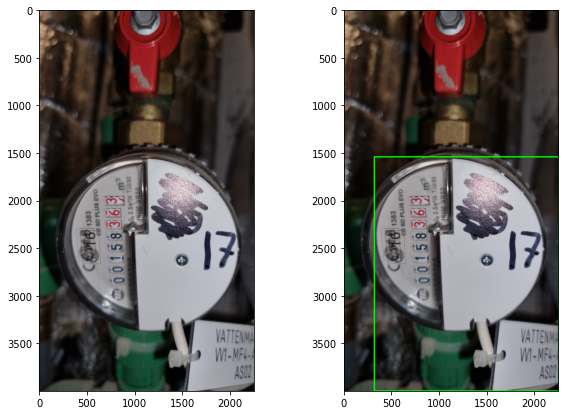

In [21]:
img_cp = img.copy()
x, y, w, h = selectMeterLocation(img)
rect = cv.rectangle(img_cp, (x, y), (x + w, y + h), (0, 255, 0), 14)


fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 7)
_ = ax[0].imshow(img[:, :, ::-1])
_ = ax[1].imshow(img_cp[:, :, ::-1])


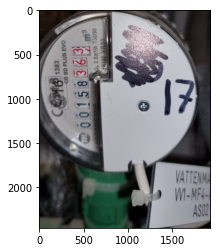

In [22]:
sel_img = img[y:y+h, x:x+w]
plt.imshow(sel_img[:,:,::-1])

In [31]:
np.prod(sel_img.shape) / np.prod(img.shape)


0.5279424955595027